- 데이콘 중고차 가격 예측 : https://dacon.io/competitions/official/235901/overview/description
- 데이터 분석 참고 : https://dacon.io/competitions/official/235901/codeshare/5085


## 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

## 데이터 불러오기


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive/dataset/used_car_price/'

/content/gdrive/My Drive/dataset/used_car_price


In [5]:
# !unzip -qq data.zip

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!ls

data.zip  sample_submission.csv  test.csv  train.csv


## 데이터 살펴보기

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [8]:
train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [9]:
test.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


In [10]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (1015, 11)
test shape: (436, 10)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            436 non-null    int64 
 1   title         436 non-null    object
 2   odometer      436 non-null    int64 
 3   location      436 non-null    object
 4   isimported    436 non-null    object
 5   engine        436 non-null    object
 6   transmission  436 non-null    object
 7   fuel          436 non-null    object
 8   paint         436 non-null    object
 9   year          436 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.2+ KB


## 중고차 가격(타겟값) 분석



### 데이터 시각화
- 그래프를 봤을때 진짜 일부가 가격대가 매우 높은것을 알 수 있음
- 나머지는 다 고만고만한듯

In [17]:
target = train['target']

<Figure size 1440x360 with 0 Axes>

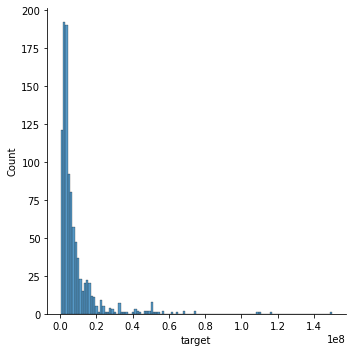

In [18]:
# 중고차 가격 분포도 - 왼쪽으로 쏠려있는 형태 주목
plt.figure(figsize = (20, 5))
sns.displot(target)

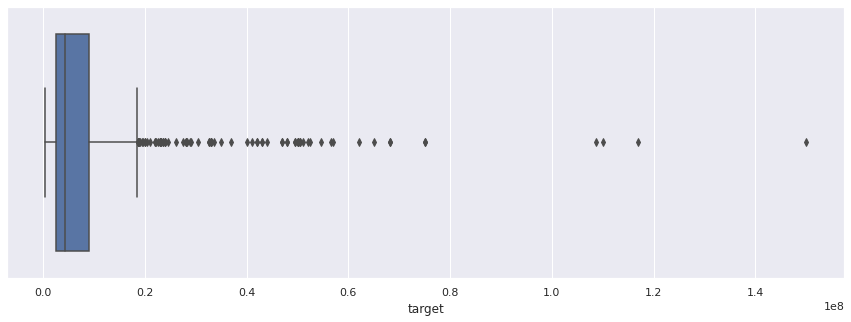

In [ ]:
# 이상치가 분명하게 보임 - 근데 이걸 제거하는게 맞나싶기도하고...
# 진짜 어쩌다 한번씩 롤스로이드? 같은 차가 매물로 나올 수도 있는거고, 이상치를 제거해버리면 제대로 예측할 수 있을까?
# 근데 찾아보면 이상치 제거는 어쩔 수 없는거 같다.
plt.figure(figsize = (15, 5))
sns.boxplot(x=target)

### 평균값과 중간값

In [19]:
# 평균값과 중간값 차이를 보면 수치로 알 수 있음
# 상위 몇퍼센트가 평균값을 다 끌어올림
print('평균값:', target.mean()) 
print('중간값:', target.median())
print('중간값과 평균값 차이:', target.median() - target.mean())

평균값: 8243204.450246305
중간값: 4215000.0
중간값과 평균값 차이: -4028204.450246305


### 절사평균
- 데이터들을 크기 순으로 나열한 후, 양끝에서 일정 비율만큼의 데이터를 삭제한 뒤 남은 값들로 평균을 구하는 방법

In [20]:
# 결과를 봤을때 10% 구간에서 크게 평균값이 감소한 것을 볼 수 있음(데이터 분포의 양 옆 10%에 이상치가 위치할 가능성이 높다)
from scipy.stats import trim_mean

for trim in [0.0, 0.1, 0.15, 0.2, 0.25]:
    print(f'{trim*100}% 절사평균 : ',trim_mean(target, trim))

0.0% 절사평균 :  8243204.450246305
10.0% 절사평균 :  5653857.329643296
15.0% 절사평균 :  5252582.29113924
20.0% 절사평균 :  4967098.536945812
25.0% 절사평균 :  4764495.106090373


### 사분위수범위

In [23]:
# 최대, 최소, 범위
print('최댓값 : ', target.max())
print('최솟값 : ', target.min())
print('범위 : ', target.max() - target.min())
print()

# 사분위수 범위
print('상위 25% : ', target.quantile(0.75))
print('하위 25% : ', target.quantile(0.25))
print('사분위수 범위 : ',target.quantile(0.75) - target.quantile(0.25))

# 결과를 통해 알수 있는점은 최댓값과 상위 25%값 사이의 차이가 굉장히 크고, 최솟값과 하위 25%값 사이의 차이는 상대적으로 작다는 것이다
# 이를 그림을 통해 그려본다면 분포가 좀 치우쳐져있다는 것을 알 수 있을 것이다. 

최댓값 :  150015008
최솟값 :  400000
범위 :  149615008

상위 25% :  8927500.0
하위 25% :  2535000.0
사분위수 범위 :  6392500.0


### 왜도와 첨도
- 왜도 : 정규분포와 비교해서 확률변수의 분포가 얼마나 치우쳐 있는지의 정도를 나타냄
    - 왜도가 0인 경우 확률변수가 정규분포에 가깝습니다.
    - 왜도가 양수인 경우 확률분포가 오른쪽으로 치우칩니다.
    - 왜도가 음수인 경우 확률분포가 왼쪽으로 치우칩니다.
- 첨도 : 첨도(kurtosis)는 양쪽 꼬리의 두터움 정도를 나타내는 값
    - 첨도가 3인 경우 확률변수가 정규분포에 가깝습니다.
    - 첨도가 3보다 큰 경우 확률분포가 정규분포보다 꼬리가 두껍습니다.
    - 첨도가 3보다 작은인 경우 확률분포가 정규분포보다 꼬리가 얇습니다.
- 정규분포 : 왜도의 기준을 절대값 2\~3을 초과하지 않고, 첨도는 절대값 7~8을 초과하지 않으면 정규분포로 볼 수 있다고 제시


In [24]:
# Dataframe의 skew() 메서드를 사용하면 왜도를 알 수 있다.
# 왜도 값이 거의 5에 가깝습니다. 따라서 데이터는 오른쪽으로 매우 치우쳐져 있습니다.
print('왜도 : ',target.skew())

왜도 :  4.9552768084421


In [25]:
# Dataframe의 kurt() 메서드를 사용하면 첨도를 알 수 있다.
# 첨도가 크다는건 꼬리가 두텁다는 뜻이고 결국 이상치(아웃라이어)가 많다는 뜻이 된다. 
print('첨도 : ', target.kurt())

첨도 :  35.55992197898911


### 도수분포표
- 변수의 범위를 동일한 크기의 계급구간으로 나눈 뒤, 각 구간마다 몇 개의 변수값이 들어가는지 보여주는 기법

In [26]:
# 계급구간을 8분위로 나눠서 얼마나 데이터가 들어가있는지 파악해보니 처음에 몰려있음을 수치적으로 확인가능
binned = pd.cut(target, 8)
binned.value_counts()

(250384.992, 19101876.0]      939
(19101876.0, 37803752.0]       40
(37803752.0, 56505628.0]       24
(56505628.0, 75207504.0]        8
(93909380.0, 112611256.0]       2
(112611256.0, 131313132.0]      1
(131313132.0, 150015008.0]      1
(75207504.0, 93909380.0]        0
Name: target, dtype: int64

### 로그정규분포 적용

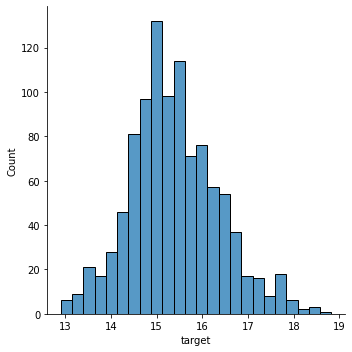

In [28]:
# 왼쪽으로 쏠려있으므로 로그정규분포 적용 - 아쉽게도 약간 치우쳐져 있음
target_log = np.log(target)
sns.displot(target_log)

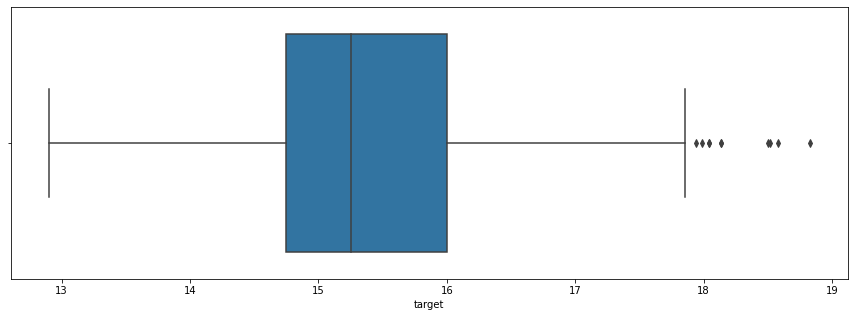

In [29]:
# 이상치가 전보다 많이 줄어들었다
plt.figure(figsize = (15, 5))
sns.boxplot(x=target_log)

In [32]:
# 0에 가까워졌으므로 정규분포라고 볼 수 있음
print(target_log.skew()) 
print(target_log.kurt())

0.37997125223034134
0.32211753773899554


### 이상치(Outlier) 제거

In [ ]:
# Outlier인 데이터 제거하기

# 1분위수 계산
Q1 = target_log.quantile(0.25)
# 3분위수 계산
Q3 = target_log.quantile(0.75)

LB = Q1 - 1.5 * (Q3 - Q1) # 아래 수염
UB = Q3 + 1.5 * (Q3 - Q1) # 위 윗수염

outlier_mask = (target_log > UB) + (target_log < LB)
outliers = target_log[outlier_mask]
outliers

332    18.038908
341    18.577813
423    17.990129
432    18.038908
569    18.516127
597    18.826246
672    18.133199
736    18.504010
774    17.942887
827    18.133199
Name: target, dtype: float64

In [ ]:
target_clean_mask = (target_log <= UB) * (target_log >= LB) # 수염 내부의 데이터에 대한 마스크만 가져옵니다.

target_clean = target_log[target_clean_mask]
target_clean

0       16.430348
1       17.312473
2       16.109559
3       15.154451
4       15.814961
          ...    
1010    15.504683
1011    15.100602
1012    15.043688
1013    16.476818
1014    16.119595
Name: target, Length: 1005, dtype: float64

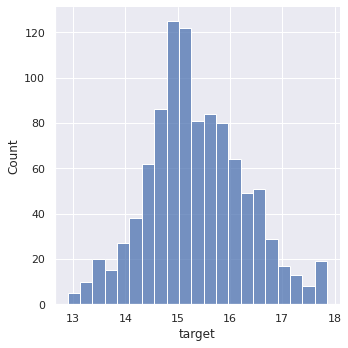

In [ ]:
sns.displot(target_clean)

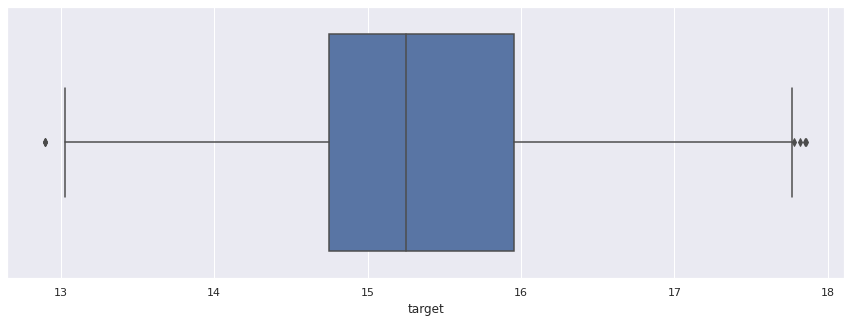

In [ ]:
plt.figure(figsize = (15, 5))
sns.boxplot(x=target_clean)

In [ ]:
train_clean = train[target_clean_mask]
train_outlier = train[~target_clean_mask]

print('정제된 데이터의 수 : ', len(train_clean))
print('이상치의 수 : ', len(train_outlier))

정제된 데이터의 수 :  1005
이상치의 수 :  10


## 수치형 데이터 분석
- 카테고리(분류)형 변수 반대이다
- 수치형 데이터는 연속형(실수)와 이산형(정수)로 나뉜다.
- 주행거리가 연속형이고, 제조년도가 이산형이 된다.

In [ ]:
# 수치형변수 불러오기
odometer = train_clean.odometer
year = train_clean.year

### 주행거리 분석

<Figure size 1440x360 with 0 Axes>

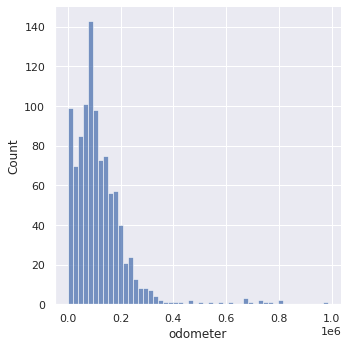

In [ ]:
# 주행거리도 보면 이상치가 좀 있네.. 상당히 많이 주행한 차들
plt.figure(figsize = (20, 5))
sns.displot(odometer)

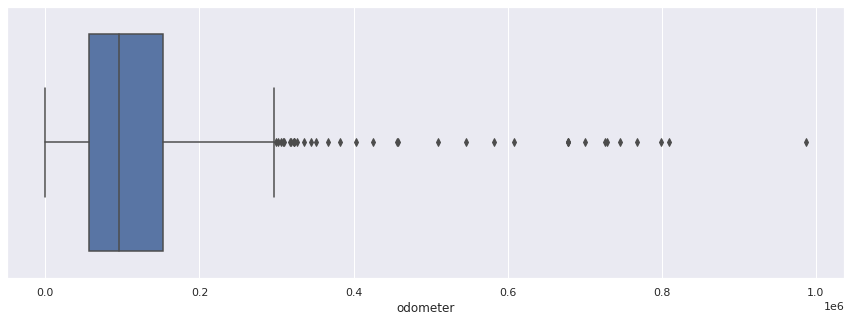

In [ ]:
# 신기한건 주행거리가 0인 매물도 있는거 같다. 실제 0인 미개봉중고인지 아니면 주행거리 측정오류로 0이 된건지는 모르겠음. 
# 어찌됐건 0인 매물도 이상치로 보는게 좋을듯하다
plt.figure(figsize = (15, 5))
sns.boxplot(x=odometer)

In [ ]:
len(train_clean[odometer == 0])

21

### 제작년도 분석

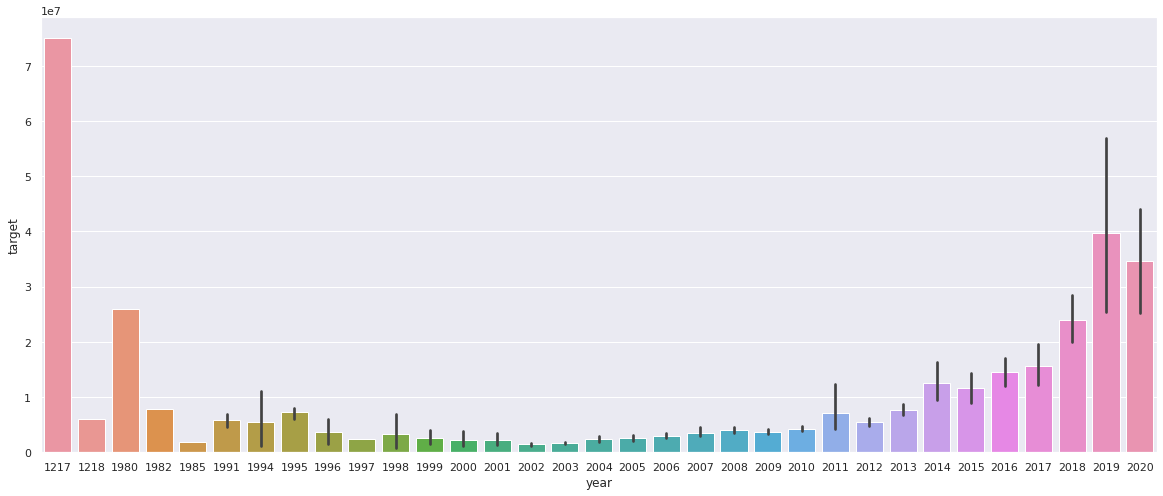

In [ ]:
# 제작년도는 거의 분류형이라고 봐도 무방할듯
# 제작년도별 타겟값을 그래프로 나타내봤는데 역시 최신 모델이 비싸게 거래되는 걸 알 수 있음
# 근데 뜬금없이 1217, 1218 이란 이상한 년도가 있음. 이건 제거해줘야겠음
sns.barplot(x='year', y='target', data=train)

In [ ]:
train_clean = train_clean[year > 1218]

### 타겟값과의 상관관계 분석

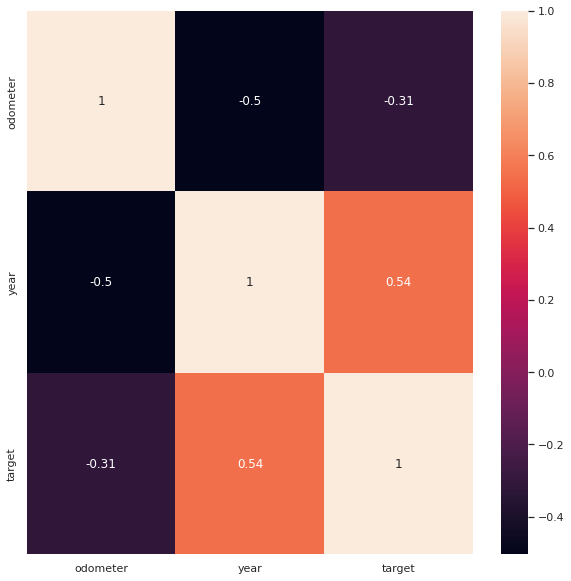

In [ ]:
# 상관관계를 보면 주행거리와 가격은 음의 관계(반비례), 제작년도와 가격은 양의 관계(비례)를 보이는 것을 알 수 있음
corrMat = train_clean[['odometer', 'year', 'target']].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrMat, annot=True)

## 분류형 데이터 분석

### 페인트 색상 분석 및 전처리

In [34]:
# 페인트 데이터를 보니까 Black하나만 해도 대소문자나 띄어쓰기 때문에 여러개가 보인다..
# 이를 좀 전처리해서 통일시켜줄 필요가 있어보인다
sorted(train['paint'].unique())

[' Black',
 ' Black/Red',
 'Ash',
 'Ash and black',
 'BLACK',
 'Beige',
 'Black',
 'Black ',
 'Black and silver',
 'Black sand pearl',
 'Black.',
 'Blue',
 'Blue ',
 'Brown',
 'Cream',
 'Cream ',
 'DARK GREY',
 'Dark Ash',
 'Dark Blue',
 'Dark Green',
 'Dark Grey',
 'Dark ash',
 'Dark blue ',
 'Dark gray',
 'Dark silver ',
 'Deep Blue',
 'Deep blue',
 'GOLD',
 'Gery',
 'Gold',
 'Gold ',
 'Gray',
 'Gray ',
 'Green',
 'Green ',
 'Grey',
 'Grey ',
 'Ink blue',
 'Light Gold',
 'Light blue',
 'Light silver ',
 'Magnetic Gray',
 'Magnetic Gray Metallic',
 'Maroon',
 'Midnight Black Metal',
 'Milk',
 'Navy blue',
 'Off white',
 'Off white l',
 'Pale brown',
 'Purple',
 'Red',
 'Redl',
 'SILVER',
 'Silver',
 'Silver ',
 'Silver/grey',
 'Sky blue',
 'Skye blue',
 'Sliver',
 'Super White',
 'WHITE',
 'WINE',
 'Whine ',
 'White',
 'White ',
 'White orchild pearl',
 'Wine',
 'Yellow',
 'blue',
 'green',
 'orange',
 'red',
 'white',
 'white-blue',
 'yellow']

In [35]:
import re 

def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','',review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        corpus.append(review) 
        
    return corpus

In [36]:
temp = clean_text(train['paint'])
train['paint'] = temp

In [37]:
# 전처리하니까 마음이 편안해진다
train['paint'].unique()

array(['red', 'black', 'gray', 'white', 'blue', 'redl', 'silver',
       'blackred', 'deep blue', 'dark grey', 'brown', 'grey', 'green',
       'purple', 'gold', 'dark blue', 'milk', 'midnight black metal',
       'beige', 'dark ash', 'orange', 'cream', 'dark gray', 'sliver',
       'white orchild pearl', 'dark green', 'yellow', 'light gold',
       'wine', 'whiteblue', 'magnetic gray', 'dark silver', 'silvergrey',
       'ink blue', 'light blue', 'sky blue', 'gery', 'pale brown',
       'whine', 'black and silver', 'light silver', 'black sand pearl',
       'off white', 'ash', 'maroon', 'navy blue', 'super white',
       'ash and black', 'magnetic gray metallic', 'skye blue',
       'off white l'], dtype=object)

In [38]:
# deep blue, ink blue, navy blue 같은거는 그냥 blue로 통일시키는 것처럼 몇가지 색상으로 통일시켜줌
# 근데 black and sliver 같은 경우는 좀 애매하네...
train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [39]:
train['paint'].unique()

array(['red', 'black', 'grey', 'white', 'blue', 'silver', 'brown',
       'green', 'purple', 'gold', 'milk', 'beige', 'ash', 'orange',
       'cream', 'yellow', 'wine', 'maroon'], dtype=object)

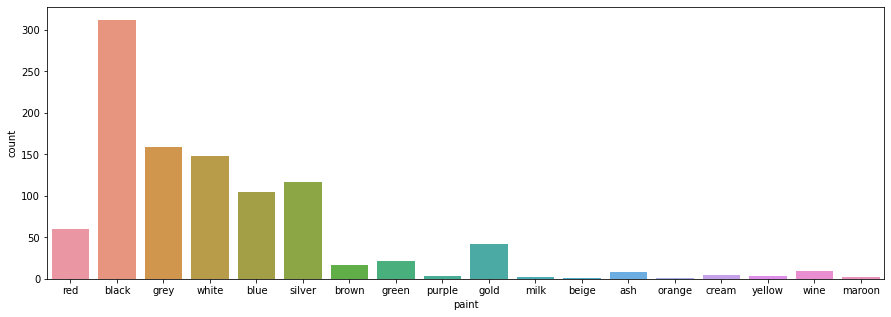

In [43]:
plt.figure(figsize = (15, 5))
sns.countplot(x='paint', data=train)

### 차량 엔진 분석

In [44]:
train['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '8-cylinder(V8)',
       '6-cylinder(I6)', '4-cylinder(H4)', '5-cylinder(I5)',
       '3-cylinder(I3)', '2-cylinder(I2)'], dtype=object)

In [45]:
# 훈련데이터에 없는 12-cylinder(V12)는 어쩔수없을듯... 훈련데이터셋을 보강하던가 그래야하지 않나
test['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '6-cylinder(I6)',
       '8-cylinder(V8)', '5-cylinder(I5)', '2-cylinder(I2)',
       '12-cylinder(V12)', '3-cylinder(I3)'], dtype=object)

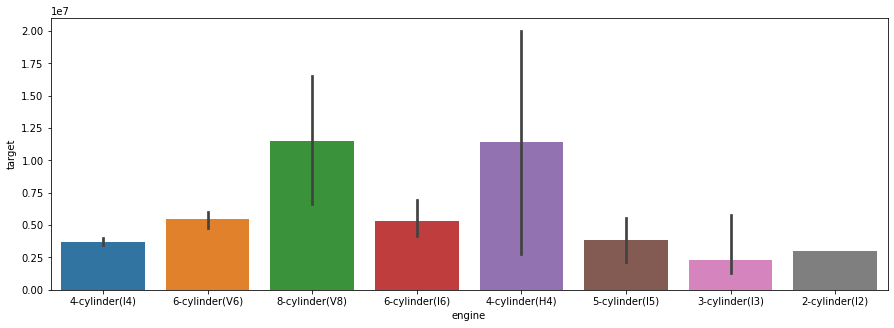

In [53]:
# 음... 엔진별로 가격차이가 있는걸로 봐서 연관은 있어보이는데
plt.figure(figsize = (15, 5))
sns.barplot(data=train, x='engine', y='target', estimator=np.median)

### 연료 분석

In [47]:
train['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

In [49]:
test['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

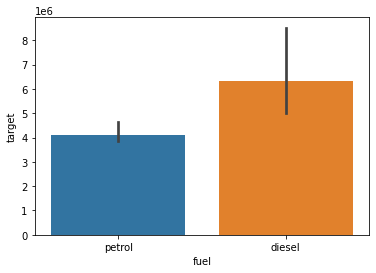

In [51]:
# 연료랑 중고차 가격이랑 상관관계가 있을까? 중간값으로 봤을때 디젤이 가솔린보다 좀 더 비싼듯(실제 찾아보니까 그런듯)
sns.barplot(data=train, x='fuel', y='target', estimator=np.median)

### 브랜드 분석 및 전처리